# Entrenamiento del Modelo de Clasificación de Páginas de PDF

Este notebook entrena un modelo de CNN para identificar las primeras páginas en documentos PDF.

In [28]:
# Importar librerías necesarias
import sys
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar rutas
PROCESSED_DIR = '../data/processed'
LABELS_FILE = '../data/labels.json'
MODEL_DIR = '../data/models'
os.makedirs(MODEL_DIR, exist_ok=True)

In [29]:
# Verificar archivos y directorios
print("Verificando archivos y directorios...")
if not os.path.exists(LABELS_FILE):
    raise FileNotFoundError(f"No se encontró el archivo de etiquetas: {LABELS_FILE}")
if not os.path.exists(PROCESSED_DIR):
    raise FileNotFoundError(f"No se encontró el directorio de imágenes procesadas: {PROCESSED_DIR}")
print("✓ Verificación completada")

Verificando archivos y directorios...
✓ Verificación completada


In [30]:
# Cargar y preparar datos
print("Preparando datos para entrenamiento...")
with open(LABELS_FILE, 'r') as f:
    labels = json.load(f)

X = []
y = []

for pdf_name, info in labels.items():
    pdf_dir = os.path.join(PROCESSED_DIR, pdf_name)
    if not os.path.exists(pdf_dir):
        print(f"Advertencia: No se encontró el directorio para {pdf_name}")
        continue
        
    total_pages = info['total_pages']
    target_pages = info['target_pages']
    
    for page in range(total_pages):
        img_path = os.path.join(pdf_dir, f'page_{page}.png')
        if not os.path.exists(img_path):
            print(f"Advertencia: No se encontró la página {page} de {pdf_name}")
            continue
            
        # Cargar y preprocesar imagen
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        X.append(img[..., np.newaxis])
        y.append(1 if page in target_pages else 0)

X = np.array(X)
y = np.array(y)

print(f"✓ Datos preparados:")
print(f"  - Total de imágenes: {len(X)}")
print(f"  - Primeras páginas: {sum(y)}")
print(f"  - Otras páginas: {len(y) - sum(y)}")

Preparando datos para entrenamiento...
✓ Datos preparados:
  - Total de imágenes: 30
  - Primeras páginas: 3
  - Otras páginas: 27


In [31]:
# Dividir datos y configurar aumentación
print("Configurando datos de entrenamiento...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcular pesos de clase para manejar desbalanceo
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Configurar aumentación de datos
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

print(f"✓ Conjunto de entrenamiento: {len(X_train)} imágenes")
print(f"✓ Conjunto de validación: {len(X_val)} imágenes")

Configurando datos de entrenamiento...
✓ Conjunto de entrenamiento: 24 imágenes
✓ Conjunto de validación: 6 imágenes


In [32]:
# Definir modelo mejorado
print("Construyendo modelo...")
model = Sequential([
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Capas densas
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar con métricas adicionales
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Construyendo modelo...


c:\Users\Steev\Documents\AiranFranco\tributai  IA\document_classifier\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,369 (42.64 MB)

 Trainable params: 11,177,537 (42.64 MB)

 Non-trainable params: 832 (3.25 KB)

In [33]:
# Entrenar modelo
print("Iniciando entrenamiento...")

# Callbacks mejorados
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, 'best_model.h5'),
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.00001
    )
]

# Entrenar con datos aumentados
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Iniciando entrenamiento...
Epoch 1/50


c:\Users\Steev\Documents\AiranFranco\tributai  IA\document_classifier\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5000 - loss: 1.3341 - precision: 0.0909 - recall: 0.3333

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 1.3341 - precision: 0.0909 - recall: 0.3333 - val_accuracy: 0.0000e+00 - val_loss: 1.0308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7083 - loss: 0.4351 - precision: 0.3000 - recall: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7083 - loss: 0.4351 - precision: 0.3000 - recall: 1.0000 - val_accuracy: 0.0000e+00 - val_loss: 0.8975 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 0.3915 - precision: 0.3333 - recall: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.3915 - precision: 0.3333 - recall: 1.0000 - val_accuracy: 0.0000e+00 - val_loss: 0.7865 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5833 - loss: 0.7857 - precision: 0.1818 - recall: 0.6667

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5833 - loss: 0.7857 - precision: 0.1818 - recall: 0.6667 - val_accuracy: 0.3333 - val_loss: 0.6986 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5417 - loss: 0.8364 - precision: 0.1667 - recall: 0.6667

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5417 - loss: 0.8364 - precision: 0.1667 - recall: 0.6667 - val_accuracy: 0.8333 - val_loss: 0.6267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7083 - loss: 0.5732 - precision: 0.3000 - recall: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7083 - loss: 0.5732 - precision: 0.3000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.6173 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5417 - loss: 0.7267 - precision: 0.1667 - recall: 0.6667 - val_accuracy: 0.6667 - val_loss: 0.6891 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6250 - loss: 0.5054 - precision: 0.2500 - recall: 1.0000 - val_accuracy: 0.1667 - val_loss: 0.7993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7083 - loss: 0.6613 - precision: 0.2500 - recall: 0.6667 - val_accuracy: 0.0000e+00 - val_loss: 0.9260 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy:

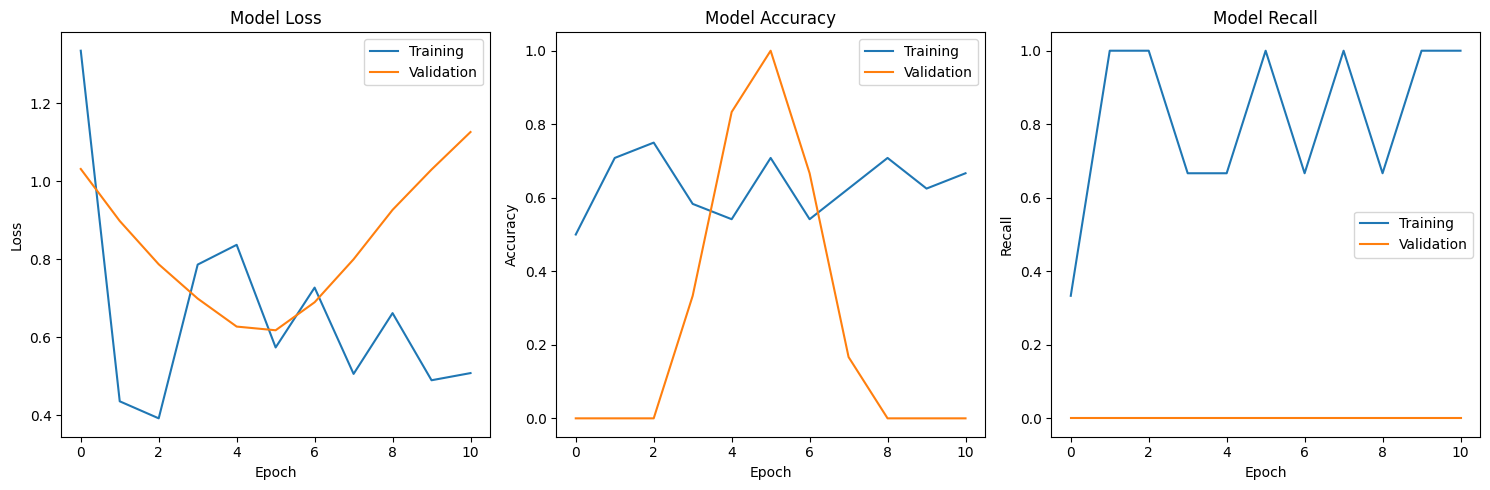

✓ Gráficos guardados en ../data/models\training_history.png


<Figure size 640x480 with 0 Axes>

In [34]:
# Visualizar resultados
plt.figure(figsize=(15, 5))

# Gráfico de pérdida
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de recall
plt.subplot(1, 3, 3)
plt.plot(history.history['recall'], label='Training')
plt.plot(history.history['val_recall'], label='Validation')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar gráficos
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'))
print("✓ Gráficos guardados en", os.path.join(MODEL_DIR, 'training_history.png'))

In [35]:
# Evaluar modelo
print("\nEvaluación final del modelo:")
metrics = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {metrics[0]:.4f}")
print(f"Accuracy: {metrics[1]:.4f}")
print(f"Precision: {metrics[2]:.4f}")
print(f"Recall: {metrics[3]:.4f}")

# Verificar guardado del modelo
model_path = os.path.join(MODEL_DIR, 'best_model.h5')
if os.path.exists(model_path):
    print(f"\n✓ Modelo guardado correctamente en {model_path}")
else:
    print("\nError: El modelo no se guardó correctamente")


Evaluación final del modelo:
Loss: 0.6173
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000

✓ Modelo guardado correctamente en ../data/models\best_model.h5
